In [195]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
# os.environ['NUMBA_DISABLE_JIT'] = '1'  # uncomment this if you want to use pypfopt within simulation
from numba import njit
from scipy.sparse import csr_matrix
import re

# from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns
# from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import create_order_nb, auto_call_seq_ctx_nb
from vectorbt.portfolio.enums import SizeType, Direction

### Read this again

I need to take full advantage of the indexing before i start bulding stuff outside of it. Reread this to understand how he's doing a dict of multiple cols or whatev. Its multi asset. https://polakowo.medium.com/stop-loss-trailing-stop-or-take-profit-2-million-backtests-shed-light-dde23bda40be



In [647]:
# df = pd.read_csv('/Users/xbno/Downloads/pred_bt_gt_1_lo.csv.gz')
df = pd.read_csv('/Users/xbno/Downloads/leftjoin.csv')
df['oc_hx_date'] = pd.to_datetime(df['oc_hx_date'])
df['s_hx_date'] = pd.to_datetime(df['s_hx_date'])
df.set_index(["oc_hx_date", "oc_hx_contract_symbol"], inplace=True)
df = df.sort_index()

### Random entry/exit from readme

Creates random entry/exit pairs. Overwrite and buy at first peak. Used to figure out proper format and play with structure.

In [648]:
rand = vbt.RAND.run(n=[i for i in range(df_tmp.shape[1])], input_shape=(df_tmp.shape[0],), seed=42)
entries = rand.entries
exits = rand.exits

entries.iloc[:,:] = False
entries.iloc[0,:] = True
exits.iloc[:,:] = False

In [649]:
def parse_contract_symbol(cs):
    "expects contract symbol like 'WKHS200717C00002500' and returns formatted versions of gleenable info to add to df"

    price_part = cs[-8:]
    option_type = cs[-9]
    date_part = cs[-15:-9]
    root_part = cs[:-15]
    symbol_part = re.match("[A-Z]*", root_part).group()

    price_part = int(price_part) / 1000
    type_part = {"C": "CALL", "P": "PUT"}[option_type]
    date_part = datetime.strptime(date_part, "%y%m%d").strftime("%Y-%m-%d")

    return {
        "option_expiration": date_part,
        "symbol": symbol_part,
        "root": root_part,
        "strike": price_part,
        "type": type_part,
    }

In [650]:
# entry_df = df.reset_index()[['oc_hx_date','oc_hx_contract_symbol','contract_symbol']].dropna(how='any')

# entry_df['oc_hx_date'] = entry_df['oc_hx_date'].astype(str)
# # entry_d = {k:v[0] for k,v in zip(entry_df.set_index(['oc_hx_date','oc_hx_contract_symbol']).to_dict('split')['index'],entry_df.set_index(['oc_hx_date','oc_hx_contract_symbol']).to_dict('split')['data'])}
# entry_d = {k:1000 for k,v in zip(entry_df.set_index(['oc_hx_date','oc_hx_contract_symbol']).to_dict('split')['index'],entry_df.set_index(['oc_hx_date','oc_hx_contract_symbol']).to_dict('split')['data'])}

# import collections

# entry_d = collections.Counter()
# entry_df['oc_hx_date'] = entry_df['oc_hx_date'].astype(str)
# for k,v in zip(entry_df.set_index(['oc_hx_date','oc_hx_contract_symbol']).to_dict('split')['index'],entry_df.set_index(['oc_hx_date','oc_hx_contract_symbol']).to_dict('split')['data']):
#     entry_d[k] += 1
# for k in entry_df.set_index(['oc_hx_date','oc_hx_contract_symbol']).to_dict('split')['index']:
#     entry_d[(parse_contract_symbol(k[1])['option_expiration'],k[1])] -= 1

# entry_d = {k:v*1000 for k,v in entry_d.items()}

# row = []
# col = []
# data = []
# for i,r in enumerate(df.reset_index()['oc_hx_date'].astype(str).unique()):
#     for j,c in enumerate(df.reset_index()['oc_hx_contract_symbol'].unique()):
#         if entry_d.get((r,c)):
#             row.append(i)
#             col.append(j)
#             data.append(entry_d[r,c])
#         else:
#             continue

# col_size = j+1
# row_size = i+1

# entry_exit_sz = csr_matrix((data, (row, col)), shape=((row_size,col_size))).toarray()

# pd.DataFrame(entry_exit_sz)

### Create entry/exit for vectorbt - fails on local due to int32 overflow/mem

Same shape as option_contract price history. Need to shift these 1 position downward so to simulate buying the next day.

These are the trades to copy:

In [651]:
df.dropna(subset=['contract_symbol']).head(5)

contract_symbol    y_pred  purch_date  \
oc_hx_date oc_hx_contract_symbol                                              
2020-12-08 FEYE201218C00016000    FEYE201218C00016000  1.745762  2020-12-08   
           FEYE210115C00016000    FEYE210115C00016000  1.227066  2020-12-08   
           FEYE210115C00017000    FEYE210115C00017000  2.011813  2020-12-08   
2020-12-09 FEYE210115C00015000    FEYE210115C00015000  1.074493  2020-12-09   
2020-12-14 FEYE201224C00014000    FEYE201224C00014000  1.710953  2020-12-14   

                                           purch_datetime  trade_price  win  \
oc_hx_date oc_hx_contract_symbol                                              
2020-12-08 FEYE201218C00016000    2020-12-08 15:31:04.223         0.24  1.0   
           FEYE210115C00016000    2020-12-08 10:59:09.849         0.66  1.0   
           FEYE210115C00017000    2020-12-08 13:38:55.160         0.37  1.0   
2020-12-09 FEYE210115C00015000    2020-12-09 12:14:45.025         0.55  1.0   
2020-12-14 FEYE201224C00014000    2020-12-14 10:51:46.350         0.44  1.0   

                                  loss  close_day_of_exp    exp_pct  \
oc_hx_date oc_hx_contract_symbol                                      
2020-12-08 FEYE201218C00016000     0.0              3.12  12.000000   
           FEYE210115C00016000     0.0              6.05   8.166667   
           FEYE210115C00017000     0.0              5.40  13.594595   
2020-12-09 FEYE210115C00015000     0.0              7.00  11.727273   
2020-12-14 FEYE201224C00014000     0.0              8.20  17.636364   

                                  future_intra_hi  ...  oc_hx_hi  oc_hx_lo  \
oc_hx_date oc_hx_contract_symbol                   ...                       
2020-12-08 FEYE201218C00016000               3.76  ...      0.29      0.20   
           FEYE210115C00016000               9.53  ...      0.69      0.63   
           FEYE210115C00017000               8.50  ...      0.39      0.35   
2020-12-09 FEYE210115C00015000              10.50  ...      0.58      0.41   
2020-12-14 FEYE201224C00014000              10.80  ...      0.50      0.23   

                                  oc_hx_open oc_hx_close  s_hx_symbol  \
oc_hx_date oc_hx_contract_symbol                                        
2020-12-08 FEYE201218C00016000          0.20        0.24         FEYE   
           FEYE210115C00016000          0.65        0.65         FEYE   
           FEYE210115C00017000          0.36        0.37         FEYE   
2020-12-09 FEYE210115C00015000          0.50        0.47         FEYE   
2020-12-14 FEYE201224C00014000          0.47        0.32         FEYE   

                                  s_hx_hi  s_hx_lo  s_hx_open s_hx_close  \
oc_hx_date oc_hx_contract_symbol                                           
2020-12-08 FEYE201218C00016000      15.66    15.31     15.310      15.52   
           FEYE210115C00016000      15.66    15.31     15.310      15.52   
           FEYE210115C00017000      15.66    15.31     15.310      15.52   
2020-12-09 FEYE210115C00015000      14.24    13.45     14.080      13.49   
2020-12-14 FEYE201224C00014000      14.10    13.62     13.915      13.67   

                                  s_hx_date  
oc_hx_date oc_hx_contract_symbol             
2020-12-08 FEYE201218C00016000   2020-12-08  
           FEYE210115C00016000   2020-12-08  
           FEYE210115C00017000   2020-12-08  
2020-12-09 FEYE210115C00015000   2020-12-09  
2020-12-14 FEYE201224C00014000   2020-12-14  

[5 rows x 24 columns]

### Create entry/exit for vectorbt - Working with leftjoin.csv

Same shape as option_contract price history. Need to shift these 1 position downward so to simulate buying the next day.

These are the trades to copy:

In [652]:
entry_df = df.reset_index().groupby(['oc_hx_date','oc_hx_contract_symbol'])['contract_symbol'].last().unstack()
entry_df = entry_df.shift(1)
entry_df = entry_df.fillna(False)
entry_df = entry_df.replace({c:True for c in entry_df.columns})
# entry_df.columns = df_tmp.columns

In [653]:
assert entry_df.loc['2020-12-08'].all() == False  # original trade check
assert entry_df.loc['2020-12-09'].sum() == 3  # shifted check
assert (entry_df.loc['2020-12-09'][entry_df.loc['2020-12-09'] == True].index
    == 
    ['FEYE201218C00016000', 'FEYE210115C00016000', 'FEYE210115C00017000']).all()  # shifted check

In [688]:
def parse_contract_symbol(cs):
    "expects contract symbol like 'WKHS200717C00002500' and returns formatted versions of gleenable info to add to df"
    if isinstance(cs,str):
        cs = cs
#     elif isinstance(cs,pd.DataFrame):
#         cs = row['contract_symbol']
#     elif isinstance(cs,pd.Series):
#         cs = row['contract_symbol']
    else:
        cs = cs['contract_symbol']
    price_part = cs[-8:]
    option_type = cs[-9]
    date_part = cs[-15:-9]
    root_part = cs[:-15]
    symbol_part = re.match("[A-Z]*", root_part).group()

    price_part = int(price_part) / 1000
    type_part = {"C": "CALL", "P": "PUT"}[option_type]
    date_part = datetime.strptime(date_part, "%y%m%d").strftime("%Y-%m-%d")

    return {
        "option_expiration": date_part,
        "symbol": symbol_part,
        "root": root_part,
        "strike": price_part,
        "type": type_part,
    }

In [689]:
exp_exit_df = entry_df.copy()
exp_exit_df.iloc[:,:] = False

entry_exit_df = df.dropna(subset=['contract_symbol'])
entry_exit_df[['option_expiration','symbol','root','strike','type']] = entry_exit_df.apply(parse_contract_symbol,axis=1,result_type="expand")
entry_exit_df = entry_exit_df[['contract_symbol','option_expiration','purch_date']].drop_duplicates()

exits = entry_exit_df[['contract_symbol','option_expiration']].drop_duplicates().to_dict('records')

for exit in exits:
    exp_exit_df.loc[exit['option_expiration'],exit['contract_symbol']] = True

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [753]:
rand_exit_types = [f'rand_{i}' for i in range(10)]
rand_exit_dfs = pd.DataFrame([])
rand_exit_dfs = {}
for rand_exit_type in rand_exit_types:
    rand_exit_df = vbt.IRPROBEX.run(
        entry_df, 
        df_tmp,
    ).exits
    rand_exit_df.columns = entry_df.columns
    rand_exit_dfs[rand_exit_type] = rand_exit_df

### Create multiple random exits

Compare random exits to the exiting at expiration

In [772]:
for r in rand_exit_types:
    print(f"rand_exit_dfs['{r}'],")

rand_exit_dfs['rand_0'],
rand_exit_dfs['rand_1'],
rand_exit_dfs['rand_2'],
rand_exit_dfs['rand_3'],
rand_exit_dfs['rand_4'],
rand_exit_dfs['rand_5'],
rand_exit_dfs['rand_6'],
rand_exit_dfs['rand_7'],
rand_exit_dfs['rand_8'],
rand_exit_dfs['rand_9'],


In [773]:
exit_types = rand_exit_types + ['expiration']
# exit_types = ['rand','expiration']
all_exit_df = pd.DataFrame.vbt.concat(
#     *rand_exit_dfs,  # doesn't work :(
    rand_exit_dfs['rand_0'],
    rand_exit_dfs['rand_1'],
    rand_exit_dfs['rand_2'],
    rand_exit_dfs['rand_3'],
    rand_exit_dfs['rand_4'],
    rand_exit_dfs['rand_5'],
    rand_exit_dfs['rand_6'],
    rand_exit_dfs['rand_7'],
    rand_exit_dfs['rand_8'],
    rand_exit_dfs['rand_9'],
    exp_exit_df,
    keys=pd.Index(exit_types, name='exit_type')
)

In [777]:
# assert rand_exit_df.sum().sum() == 9  # does this need to be 12?

### Setup wide data for vectorbt

One column per option_contract series

In [778]:
df_tmp = df[[c for c in df.columns if 'oc_hx' in c]]
df_tmp = df_tmp.reset_index().set_index('oc_hx_date') #.set_index('oc_hx_symbol')
df_tmp = df_tmp.sort_index()
df_tmp = df_tmp.groupby(['oc_hx_date','oc_hx_contract_symbol'])['oc_hx_close'].max().unstack().dropna(how='all')

for exit in exits:
    df_tmp.loc[:exit['option_expiration'],exit['contract_symbol']] = df_tmp.loc[:exit['option_expiration'],exit['contract_symbol']].ffill()

df_tmp.index.name = 'Date'

df_tmp_save = df_tmp.copy()
symbols = df_tmp.columns
df_tmp = df_tmp.vbt.stack_index(pd.Index([re.match('[A-Z]*',c)[0] for c in df_tmp.columns], name='symbol'))
df_tmp

symbol                               AMC                                   BB  \
oc_hx_contract_symbol AMC210122C00002500 AMC210122C00003000 BB210108C00007000   
Date                                                                            
2019-01-02                           NaN                NaN               NaN   
2019-01-04                           NaN                NaN               NaN   
2019-01-14                           NaN                NaN               NaN   
2019-01-15                           NaN                NaN               NaN   
2019-01-18                           NaN                NaN               NaN   
...                                  ...                ...               ...   
2021-01-15                          0.36               0.21               NaN   
2021-01-19                          0.61               0.35               NaN   
2021-01-20                          0.53               0.19               NaN   
2021-01-21                          0.47               0.09               NaN   
2021-01-22                          1.00               0.50               NaN   

symbol                                                 FEYE  \
oc_hx_contract_symbol BB210122C00007000 FEYE201218C00016000   
Date                                                          
2019-01-02                          NaN                 NaN   
2019-01-04                          NaN                 NaN   
2019-01-14                          NaN                 NaN   
2019-01-15                          NaN                 NaN   
2019-01-18                          NaN                 NaN   
...                                 ...                 ...   
2021-01-15                         2.89                 NaN   
2021-01-19                         5.30                 NaN   
2021-01-20                         5.70                 NaN   
2021-01-21                         5.80                 NaN   
2021-01-22                         7.00                 NaN   

symbol                                                         \
oc_hx_contract_symbol FEYE201224C00014000 FEYE210115C00015000   
Date                                                            
2019-01-02                            NaN                4.80   
2019-01-04                            NaN                5.10   
2019-01-14                            NaN                5.15   
2019-01-15                            NaN                5.07   
2019-01-18                            NaN                5.07   
...                                   ...                 ...   
2021-01-15                            NaN                7.00   
2021-01-19                            NaN                 NaN   
2021-01-20                            NaN                 NaN   
2021-01-21                            NaN                 NaN   
2021-01-22                            NaN                 NaN   

symbol                                                         
oc_hx_contract_symbol FEYE210115C00016000 FEYE210115C00017000  
Date                                                           
2019-01-02                            NaN                 3.9  
2019-01-04                            NaN                 4.2  
2019-01-14                            NaN                 4.2  
2019-01-15                            NaN                 4.2  
2019-01-18                            NaN                 4.1  
...                                   ...                 ...  
2021-01-15                           6.05                 5.4  
2021-01-19                            NaN                 NaN  
2021-01-20                            NaN                 NaN  
2021-01-21                            NaN                 NaN  
2021-01-22                            NaN                 NaN  

[440 rows x 9 columns]

In [779]:
assert df_tmp.shape == entry_df.shape == exit_df.shape

### Show trades

This is excellent! Potentially figure out how to add this to a dashboard with a selector. 

Inspiration also here: https://nbviewer.jupyter.org/github/polakowo/vectorbt/blob/master/examples/PortfolioOptimization.ipynb Looks like there could be a much better way of indexing these.


### Dashboard inspiration
Probably will need to create a dashboard using dash components: https://github.com/facultyai/dash-bootstrap-components like this: https://github.com/polakowo/vectorbt/tree/master/apps/candlestick-patterns.

Example here: https://candlestick-patterns.herokuapp.com/

In [780]:
# df_amc = df_tmp['AMC210122C00002500'].dropna()
# contract_symbol = 'AMC210122C00002500'

# exit_df = rand_exit_df.copy()
exit_df = exp_exit_df.copy()
exit_df.columns = df_tmp.columns
entry_df.columns = df_tmp.columns

contract_symbol = df_tmp.columns[3]

fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'))
fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

contract_symbol = df_tmp.columns[4]
fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'), fig=fig)
fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

fig.show()

In [781]:
symbol = 'FEYE'
contract_symbols = [c for c in df_tmp.columns if symbol in c]
contract_symbol = contract_symbols[0]
fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'))
fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

for contract_symbol in contract_symbols[1:]:
    fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'), fig=fig)
    fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
    fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

fig.show()

### Create vectorbt portfolio.from_orders()

Join entry_df and exit_df that had been created for the signals version to create +/- values for orders

In [782]:
entry_sz = entry_df.astype(int) * 10 * 100
exit_sz = exit_df.astype(int) * entry_sz.sum()
entry_exit_sz = entry_sz - exit_sz

# converts old pandas entry_exit_sz sparse version (didn't work as sparse, so unnecessary)
row = []
col = []
data = []
for i,r in enumerate(entry_exit_sz.index):
    for j,c in enumerate(entry_exit_sz.columns):
        if entry_exit_sz.loc[r,c] == 0:
            continue
        else:
            row.append(i)
            col.append(j)
            data.append(entry_exit_sz.loc[r,c])

col_size = j+1
row_size = i+1

# entry_exit_sz = csr_matrix((data, (row, col)), shape=((row_size,col_size)))  # doesnt' work
entry_exit_sz = csr_matrix((data, (row, col)), shape=((row_size,col_size))).toarray()

In [783]:
portfolio = vbt.Portfolio.from_orders(
#     df_tmp,
    price,
    size=entry_exit_sz, 
    min_size=0,
    max_size=10000, 
#     group_by=True,
#     group_by=symbol_groups, 
    log=True, 
    fees=0.001, 
    slippage=0.001,
#     init_cash='auto',
    init_cash='autoalign',
#     cash_sharing=True, 
    direction='longonly',
    freq='1D',
)

portfolio.total_return()

symbol  oc_hx_contract_symbol
AMC     AMC210122C00002500        1.925292
        AMC210122C00003000        0.764844
BB      BB210108C00007000         0.492093
        BB210122C00007000        14.608914
FEYE    FEYE201218C00016000       3.337961
        FEYE201224C00014000       8.458534
        FEYE210115C00015000      14.323200
        FEYE210115C00016000       6.270163
        FEYE210115C00017000       5.679608
dtype: float64

# Brainstorming

### Entry logic
- Only buy at 1/2 price of original trade
- Buy X at orig price, Y at .75 * orig price, Z at .5 * orig price. Good til expired
- 

### Exit logic
- Set X% stop loss for Z% of shares, after Y% increase
    - Sell 1/2 of shares at 20% max drawdown, after hitting 50% increase
- Sell Z% of shares after Y% increase 
    - Sell all shares after 100% increase
    - Sell 1/2 shares after 100% increase and other 1/2 after 200% increase

### Create vectorbt portfolio.from_orders()

Create rand exiting to compare to expiration exiting. Inspired from: https://nbviewer.jupyter.org/github/polakowo/vectorbt/blob/master/examples/StopSignals.ipynb

The idea is that if I can create exit signals based on actual functions than I can actually beomce confident in which is the best/safest method overall.

- Entry signal same for all
- Exit signal random each time

In [793]:
import gc

total_returns = []
for exit_type in exit_types:
    entry_sz = entry_df.copy().astype(int) * 10 * 100
    chunk_exit_df = all_exit_df.loc[:,all_exit_df.columns.get_level_values('exit_type') == exit_type]
    entry_sz.columns = chunk_exit_df.columns
    exit_sz = chunk_exit_df.astype(int) * entry_sz.sum()
    entry_exit_sz = entry_sz - exit_sz
    
    portfolio = vbt.Portfolio.from_orders(
        df_tmp,  # grouped by exit_type, symbol, contract_symbol
        size=entry_exit_sz, 
        min_size=0,
        max_size=10000, 
        log=True, 
        fees=0.001, 
        slippage=0.001,
        init_cash='autoalign',
        direction='longonly',
        freq='1D',
    )
    total_returns.append(portfolio.total_return())

    if exit_type == 'expiration':
        pass
    else:
        del portfolio
    gc.collect()
    
total_return = pd.concat(total_returns)

print(total_return.shape)

(99,)


In [794]:
total_return_by_type = total_return.unstack(level='exit_type')[exit_types]

print(pd.DataFrame({
    'Mean': total_return_by_type.mean(),
    'Median': total_return_by_type.median(),
    'Std': total_return_by_type.std(),
}))

total_return_by_type.vbt.boxplot(
    yaxis_title='Total return',
    yaxis_tickformat='%'
).show()


                Mean    Median       Std
exit_type                               
rand_0      2.575851  0.955110  3.171259
rand_1      2.822469  1.480868  3.027007
rand_2      1.845465  0.690618  2.272893
rand_3      2.427410  0.881156  2.768123
rand_4      2.587006  0.845118  3.184118
rand_5      2.601133  0.845118  3.177833
rand_6      2.537558  0.714996  3.210819
rand_7      2.764457  1.267834  2.830677
rand_8      1.284896  0.757379  2.652395
rand_9      2.246316  0.955110  3.089504
expiration  6.206734  5.679608  5.369567


### Portfolio: Trades, Orders. Not sure what to do with these yet

In [795]:
order_df = portfolio.logs.records
order_df[order_df['order_id'] != -1]

,id,idx,col,group,cash_now,shares_now,val_price_now,value_now,size,size_type,...,log,new_cash,new_shares,res_size,res_price,res_fees,res_side,res_status,res_status_info,order_id
432,432,432,0,0,inf,0.0,0.14,inf,1000.0,0,...,True,inf,1000.0,1000.0,0.14014,0.14014,0,0,-1,0
433,433,433,0,0,inf,1000.0,0.10,inf,1000.0,0,...,True,inf,2000.0,1000.0,0.10010,0.10010,0,0,-1,1
439,439,439,0,0,inf,2000.0,1.00,inf,-2000.0,0,...,True,inf,0.0,2000.0,0.99900,1.99800,1,0,-1,2
870,870,430,1,1,inf,0.0,0.09,inf,1000.0,0,...,True,inf,1000.0,1000.0,0.09009,0.09009,0,0,-1,3
875,875,435,1,1,inf,1000.0,0.21,inf,1000.0,0,...,True,inf,2000.0,1000.0,0.21021,0.21021,0,0,-1,4
879,879,439,1,1,inf,2000.0,0.50,inf,-2000.0,0,...,True,inf,0.0,2000.0,0.49950,0.99900,1,0,-1,5
1305,1305,425,2,2,inf,0.0,0.10,inf,1000.0,0,...,True,inf,1000.0,1000.0,0.10010,0.10010,0,0,-1,6
1310,1310,430,2,2,inf,1000.0,0.55,inf,-1000.0,0,...,True,inf,0.0,1000.0,0.54945,0.54945,1,0,-1,7
1744,1744,424,3,3,inf,0.0,0.27,inf,1000.0,0,...,True,inf,1000.0,1000.0,0.27027,0.27027,0,0,-1,8
1749,1749,429,3,3,inf,1000.0,0.38,inf,1000.0,0,...,True,inf,2000.0,1000.0,0.38038,0.38038,0,0,-1,9


In [796]:
portfolio.orders.records

,id,idx,col,size,price,fees,side
0,0,432,0,1000.0,0.14014,0.14014,0
1,1,433,0,1000.0,0.10010,0.10010,0
2,2,439,0,2000.0,0.99900,1.99800,1
3,3,430,1,1000.0,0.09009,0.09009,0
4,4,435,1,1000.0,0.21021,0.21021,0
5,5,439,1,2000.0,0.49950,0.99900,1
6,6,425,2,1000.0,0.10010,0.10010,0
7,7,430,2,1000.0,0.54945,0.54945,1
8,8,424,3,1000.0,0.27027,0.27027,0
9,9,429,3,1000.0,0.38038,0.38038,0


In [797]:
portfolio.trades.records

,id,col,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl,return,direction,status,position_id
0,0,0,2000.0,432,0.120120,0.24024,439,0.99900,1.99800,1755.52176,7.307367,0,1,0
1,1,1,2000.0,430,0.150150,0.30030,439,0.49950,0.99900,697.40070,2.322347,0,1,1
2,2,2,1000.0,425,0.100100,0.10010,430,0.54945,0.54945,448.70045,4.482522,0,1,2
3,3,3,2000.0,424,0.325325,0.65065,439,6.99300,13.98600,13320.71335,20.472932,0,1,3
4,4,4,1000.0,410,0.070070,0.07007,417,3.11688,3.11688,3043.62305,43.436892,0,1,4
5,5,5,1000.0,414,0.470470,0.47047,421,8.19180,8.19180,7712.66773,16.393538,0,1,5
6,6,6,2000.0,411,0.455455,0.91091,435,6.99300,13.98600,13060.19309,14.337523,0,1,6
7,7,7,1000.0,410,0.320320,0.32032,435,6.04395,6.04395,5717.26573,17.848607,0,1,7
8,8,8,1000.0,410,0.210210,0.21021,435,5.39460,5.39460,5178.78519,24.636246,0,1,8


### Ratios, Profits, etc

When running this for all symbols, I can do ablation on the top X and figure out the what the gains would still be. If I'm clever about it, I can include the symbol price history as well, and ablate based on the gains of it? That way I could remove abnormally high winners, like AMC, BB recently.

In [798]:
drop_half = portfolio.total_return().index.shape[0] // 2

In [799]:
# portfolio.total_return(group_by='symbol')
# portfolio.total_return()
portfolio.total_return(group_by=False).sort_values(ascending=False).index[drop_half:]

MultiIndex([('expiration', 'FEYE', 'FEYE210115C00017000'),
            ('expiration', 'FEYE', 'FEYE201218C00016000'),
            ('expiration',  'AMC',  'AMC210122C00002500'),
            ('expiration',  'AMC',  'AMC210122C00003000'),
            ('expiration',   'BB',   'BB210108C00007000')],
           names=['exit_type', 'symbol', 'oc_hx_contract_symbol'])

In [800]:
unablated_contract_symbols = portfolio.total_return(group_by=False).sort_values(ascending=False).index[3:]

In [801]:
unablated_contract_symbols

MultiIndex([('expiration', 'FEYE', 'FEYE210115C00016000'),
            ('expiration', 'FEYE', 'FEYE210115C00017000'),
            ('expiration', 'FEYE', 'FEYE201218C00016000'),
            ('expiration',  'AMC',  'AMC210122C00002500'),
            ('expiration',  'AMC',  'AMC210122C00003000'),
            ('expiration',   'BB',   'BB210108C00007000')],
           names=['exit_type', 'symbol', 'oc_hx_contract_symbol'])

In [805]:
portfolio.regroup(group_by=None).total_profit().sum()

50934.87105

In [841]:
portfolio.stats()

Start                     2019-01-02 00:00:00
End                       2021-01-22 00:00:00
Duration                    440 days 00:00:00
Init. Cash                            911.821
Total Profit                          5659.43
Total Return [%]                      620.673
Benchmark Return [%]                  249.403
Position Coverage [%]                 3.13131
Max. Drawdown [%]                     21.9264
Avg. Drawdown [%]                     13.8066
Max. Drawdown Duration       11 days 16:00:00
Avg. Drawdown Duration        7 days 09:46:40
Num. Trades                                 1
Win Rate [%]                              100
Best Trade [%]                        1680.42
Worst Trade [%]                       1680.42
Avg. Trade [%]                        1680.42
Max. Trade Duration          13 days 18:40:00
Avg. Trade Duration          13 days 18:40:00
Expectancy                            5659.43
SQN                                       NaN
Gross Exposure                    

In [807]:
portfolio.sortino_ratio(group_by='symbol')

symbol
AMC      4.522777
BB      17.986749
FEYE    25.414376
dtype: float64

In [808]:
portfolio.sortino_ratio(group_by='oc_hx_contract_symbol')

oc_hx_contract_symbol
AMC210122C00002500      8.986827
AMC210122C00003000      2.380131
BB210108C00007000       9.124245
BB210122C00007000      15.888046
FEYE201218C00016000    75.730433
FEYE201224C00014000    18.304655
FEYE210115C00015000    18.242387
FEYE210115C00016000     9.243009
FEYE210115C00017000     7.604250
dtype: float64

In [809]:
portfolio.sharpe_ratio(group_by=False)

exit_type   symbol  oc_hx_contract_symbol
expiration  AMC     AMC210122C00002500       1.126305
                    AMC210122C00003000       0.668239
            BB      BB210108C00007000        0.799517
                    BB210122C00007000        1.269726
            FEYE    FEYE201218C00016000      0.744947
                    FEYE201224C00014000      0.853823
                    FEYE210115C00015000      0.832170
                    FEYE210115C00016000      0.881631
                    FEYE210115C00017000      0.915285
dtype: float64

In [817]:
portfolio.omega_ratio(risk_free=.02,required_return=.05)

exit_type   symbol  oc_hx_contract_symbol
expiration  AMC     AMC210122C00002500       0.168599
                    AMC210122C00003000       0.154569
            BB      BB210108C00007000        0.055876
                    BB210122C00007000        0.499945
            FEYE    FEYE201218C00016000      0.400207
                    FEYE201224C00014000      0.609546
                    FEYE210115C00015000      0.952345
                    FEYE210115C00016000      0.522237
                    FEYE210115C00017000      0.470659
dtype: float64

In [828]:
symbols = ["SPY"]
start = datetime(2020, 12, 1)
# end = datetime(2021, 9, 1)
end = datetime.now()
# close = vbt.utils.data.download("BTC-USD", start=start, end=end)['Close']
price_by_symbol = vbt.utils.data.download(symbols, start=start, end=end, cols='Close')
price = vbt.utils.data.concat_symbols(price_by_symbol)
returns = price.pct_change()
returns

Date
2020-12-01         NaN
2020-12-02    0.002104
2020-12-03   -0.000273
2020-12-04    0.008618
2020-12-07   -0.002055
2020-12-08    0.002926
2020-12-09   -0.008969
2020-12-10   -0.000327
2020-12-11   -0.001173
2020-12-14   -0.004477
2020-12-15    0.013519
2020-12-16    0.001569
2020-12-17    0.005592
2020-12-18   -0.003993
2020-12-21   -0.003576
2020-12-22   -0.001685
2020-12-23    0.000899
2020-12-24    0.003890
2020-12-28    0.008591
2020-12-29   -0.001908
2020-12-30    0.001427
2020-12-31    0.005081
2021-01-04   -0.013614
2021-01-05    0.006887
2021-01-06    0.005979
2021-01-07    0.014857
2021-01-08    0.005698
2021-01-11   -0.006741
2021-01-12    0.000211
2021-01-13    0.002693
2021-01-14   -0.003502
2021-01-15   -0.007293
2021-01-19    0.007852
2021-01-20    0.013839
2021-01-21    0.000912
2021-01-22   -0.003539
2021-01-25    0.003944
2021-01-26   -0.001561
2021-01-27   -0.024440
2021-01-28    0.008600
2021-01-29   -0.020020
2021-02-01    0.016646
2021-02-02    0.014140
2021-0

In [835]:
portfolio.total_return()#.stats(returns)

exit_type   symbol  oc_hx_contract_symbol
expiration  AMC     AMC210122C00002500        1.925292
                    AMC210122C00003000        0.764844
            BB      BB210108C00007000         0.492093
                    BB210122C00007000        14.608914
            FEYE    FEYE201218C00016000       3.337961
                    FEYE201224C00014000       8.458534
                    FEYE210115C00015000      14.323200
                    FEYE210115C00016000       6.270163
                    FEYE210115C00017000       5.679608
dtype: float64

In [1196]:
# portfolio.total_return()
# portfolio.value()
# # one_group = pd.Index(['one' for c in df_tmp.columns], name='group')
# # portfolio.net_exposure(group_by=symbol_groups)#.sum(axis=1).plot() #drawdown()
# portfolio.net_exposure()#.sum(axis=1).plot() #drawdown()

In [838]:
portfolio.total_profit(group_by='exit_type')

50934.87105

In [836]:
portfolio.total_profit(group_by='symbol')
# portfolio['AMC'].total_profit()

symbol
AMC      2452.92246
BB      13769.41380
FEYE    34712.53479
dtype: float64

In [839]:
portfolio.total_profit(group_by=None)

exit_type   symbol  oc_hx_contract_symbol
expiration  AMC     AMC210122C00002500        1755.52176
                    AMC210122C00003000         697.40070
            BB      BB210108C00007000          448.70045
                    BB210122C00007000        13320.71335
            FEYE    FEYE201218C00016000       3043.62305
                    FEYE201224C00014000       7712.66773
                    FEYE210115C00015000      13060.19309
                    FEYE210115C00016000       5717.26573
                    FEYE210115C00017000       5178.78519
dtype: float64

In [846]:
# portfolio.logs.records
portfolio.trades.records

,id,col,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl,return,direction,status,position_id
0,0,0,2000.0,432,0.120120,0.24024,439,0.99900,1.99800,1755.52176,7.307367,0,1,0
1,1,1,2000.0,430,0.150150,0.30030,439,0.49950,0.99900,697.40070,2.322347,0,1,1
2,2,2,1000.0,425,0.100100,0.10010,430,0.54945,0.54945,448.70045,4.482522,0,1,2
3,3,3,2000.0,424,0.325325,0.65065,439,6.99300,13.98600,13320.71335,20.472932,0,1,3
4,4,4,1000.0,410,0.070070,0.07007,417,3.11688,3.11688,3043.62305,43.436892,0,1,4
5,5,5,1000.0,414,0.470470,0.47047,421,8.19180,8.19180,7712.66773,16.393538,0,1,5
6,6,6,2000.0,411,0.455455,0.91091,435,6.99300,13.98600,13060.19309,14.337523,0,1,6
7,7,7,1000.0,410,0.320320,0.32032,435,6.04395,6.04395,5717.26573,17.848607,0,1,7
8,8,8,1000.0,410,0.210210,0.21021,435,5.39460,5.39460,5178.78519,24.636246,0,1,8


In [847]:
from vectorbt.portfolio.enums import OrderStatus
portfolio.logs.map_field('res_status', value_map=OrderStatus).value_counts()

exit_type                     expiration                                       \
symbol                               AMC                                   BB   
oc_hx_contract_symbol AMC210122C00002500 AMC210122C00003000 BB210108C00007000   
Ignored                              437                437               438   
Filled                                 3                  3                 2   

exit_type                                                    \
symbol                                                 FEYE   
oc_hx_contract_symbol BB210122C00007000 FEYE201218C00016000   
Ignored                             437                 438   
Filled                                3                   2   

exit_type                                                      \
symbol                                                          
oc_hx_contract_symbol FEYE201224C00014000 FEYE210115C00015000   
Ignored                               438                 437   
Filled                                  2                   3   

exit_type                                                      
symbol                                                         
oc_hx_contract_symbol FEYE210115C00016000 FEYE210115C00017000  
Ignored                               438                 438  
Filled                                  2                   2

In [856]:
# portfolio['AMC'].trades.plot().show()
portfolio.trades['expiration']['AMC']['AMC210122C00003000'].plot().show()
# portfolio['AMC'].plot().show()

In [911]:
# fig = portfolio.trades['expiration']['AMC']['AMC210122C00002500'].plot(subplots=[
#     'orders',
#     ('order_size', dict(
#         title='Order Size',
#         can_plot_groups=False
#     ))  # placeholder
# ])
# entry_exit_sz['expiration']['AMC']['AMC210122C00002500'].vbt.plot(add_trace_kwargs=dict(row=2, col=1), fig=fig).show()
# # portfolio['expiration']['AMC']['AMC210122C00003000'].cumulative_returns().vbt.plot(add_trace_kwargs=dict(row=2, col=1), fig=fig).show()

ValueError: Invalid property specified for object of type plotly.graph_objs.Layout: 'subplots'

Did you mean "shapes"?

    Valid properties:
        activeshape
            :class:`plotly.graph_objects.layout.Activeshape`
            instance or dict with compatible properties
        angularaxis
            :class:`plotly.graph_objects.layout.AngularAxis`
            instance or dict with compatible properties
        annotations
            A tuple of
            :class:`plotly.graph_objects.layout.Annotation`
            instances or dicts with compatible properties
        annotationdefaults
            When used in a template (as
            layout.template.layout.annotationdefaults), sets the
            default property values to use for elements of
            layout.annotations
        autosize
            Determines whether or not a layout width or height that
            has been left undefined by the user is initialized on
            each relayout. Note that, regardless of this attribute,
            an undefined layout width or height is always
            initialized on the first call to plot.
        autotypenumbers
            Using "strict" a numeric string in trace data is not
            converted to a number. Using *convert types* a numeric
            string in trace data may be treated as a number during
            automatic axis `type` detection. This is the default
            value; however it could be overridden for individual
            axes.
        bargap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        bargroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        barmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "relative", the bars
            are stacked on top of one another, with negative values
            below the axis, positive values above With "group", the
            bars are plotted next to one another centered around
            the shared location. With "overlay", the bars are
            plotted over one another, you might need to an
            "opacity" to see multiple bars.
        barnorm
            Sets the normalization for bar traces on the graph.
            With "fraction", the value of each bar is divided by
            the sum of all values at that location coordinate.
            "percent" is the same but multiplied by 100 to show
            percentages.
        boxgap
            Sets the gap (in plot fraction) between boxes of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        boxgroupgap
            Sets the gap (in plot fraction) between boxes of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        boxmode
            Determines how boxes at the same location coordinate
            are displayed on the graph. If "group", the boxes are
            plotted next to one another centered around the shared
            location. If "overlay", the boxes are plotted over one
            another, you might need to set "opacity" to see them
            multiple boxes. Has no effect on traces that have
            "width" set.
        calendar
            Sets the default calendar system to use for
            interpreting and displaying dates throughout the plot.
        clickmode
            Determines the mode of single click interactions.
            "event" is the default value and emits the
            `plotly_click` event. In addition this mode emits the
            `plotly_selected` event in drag modes "lasso" and
            "select", but with no event data attached (kept for
            compatibility reasons). The "select" flag enables
            selecting single data points via click. This mode also
            supports persistent selections, meaning that pressing
            Shift while clicking, adds to / subtracts from an
            existing selection. "select" with `hovermode`: "x" can
            be confusing, consider explicitly setting `hovermode`:
            "closest" when using this feature. Selection events are
            sent accordingly as long as "event" flag is set as
            well. When the "event" flag is missing, `plotly_click`
            and `plotly_selected` events are not fired.
        coloraxis
            :class:`plotly.graph_objects.layout.Coloraxis` instance
            or dict with compatible properties
        colorscale
            :class:`plotly.graph_objects.layout.Colorscale`
            instance or dict with compatible properties
        colorway
            Sets the default trace colors.
        computed
            Placeholder for exporting automargin-impacting values
            namely `margin.t`, `margin.b`, `margin.l` and
            `margin.r` in "full-json" mode.
        datarevision
            If provided, a changed value tells `Plotly.react` that
            one or more data arrays has changed. This way you can
            modify arrays in-place rather than making a complete
            new copy for an incremental change. If NOT provided,
            `Plotly.react` assumes that data arrays are being
            treated as immutable, thus any data array with a
            different identity from its predecessor contains new
            data.
        direction
            Legacy polar charts are deprecated! Please switch to
            "polar" subplots. Sets the direction corresponding to
            positive angles in legacy polar charts.
        dragmode
            Determines the mode of drag interactions. "select" and
            "lasso" apply only to scatter traces with markers or
            text. "orbit" and "turntable" apply only to 3D scenes.
        editrevision
            Controls persistence of user-driven changes in
            `editable: true` configuration, other than trace names
            and axis titles. Defaults to `layout.uirevision`.
        extendfunnelareacolors
            If `true`, the funnelarea slice colors (whether given
            by `funnelareacolorway` or inherited from `colorway`)
            will be extended to three times its original length by
            first repeating every color 20% lighter then each color
            20% darker. This is intended to reduce the likelihood
            of reusing the same color when you have many slices,
            but you can set `false` to disable. Colors provided in
            the trace, using `marker.colors`, are never extended.
        extendpiecolors
            If `true`, the pie slice colors (whether given by
            `piecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendsunburstcolors
            If `true`, the sunburst slice colors (whether given by
            `sunburstcolorway` or inherited from `colorway`) will
            be extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendtreemapcolors
            If `true`, the treemap slice colors (whether given by
            `treemapcolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        font
            Sets the global font. Note that fonts used in traces
            and other layout components inherit from the global
            font.
        funnelareacolorway
            Sets the default funnelarea slice colors. Defaults to
            the main `colorway` used for trace colors. If you
            specify a new list here it can still be extended with
            lighter and darker colors, see
            `extendfunnelareacolors`.
        funnelgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        funnelgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        funnelmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "group", the bars
            are plotted next to one another centered around the
            shared location. With "overlay", the bars are plotted
            over one another, you might need to an "opacity" to see
            multiple bars.
        geo
            :class:`plotly.graph_objects.layout.Geo` instance or
            dict with compatible properties
        grid
            :class:`plotly.graph_objects.layout.Grid` instance or
            dict with compatible properties
        height
            Sets the plot's height (in px).
        hiddenlabels
            hiddenlabels is the funnelarea & pie chart analog of
            visible:'legendonly' but it can contain many labels,
            and can simultaneously hide slices from several
            pies/funnelarea charts
        hiddenlabelssrc
            Sets the source reference on Chart Studio Cloud for
            hiddenlabels .
        hidesources
            Determines whether or not a text link citing the data
            source is placed at the bottom-right cored of the
            figure. Has only an effect only on graphs that have
            been generated via forked graphs from the Chart Studio
            Cloud (at https://chart-studio.plotly.com or on-
            premise).
        hoverdistance
            Sets the default distance (in pixels) to look for data
            to add hover labels (-1 means no cutoff, 0 means no
            looking for data). This is only a real distance for
            hovering on point-like objects, like scatter points.
            For area-like objects (bars, scatter fills, etc)
            hovering is on inside the area and off outside, but
            these objects will not supersede hover on point-like
            objects in case of conflict.
        hoverlabel
            :class:`plotly.graph_objects.layout.Hoverlabel`
            instance or dict with compatible properties
        hovermode
            Determines the mode of hover interactions. If
            "closest", a single hoverlabel will appear for the
            "closest" point within the `hoverdistance`. If "x" (or
            "y"), multiple hoverlabels will appear for multiple
            points at the "closest" x- (or y-) coordinate within
            the `hoverdistance`, with the caveat that no more than
            one hoverlabel will appear per trace. If *x unified*
            (or *y unified*), a single hoverlabel will appear
            multiple points at the closest x- (or y-) coordinate
            within the `hoverdistance` with the caveat that no more
            than one hoverlabel will appear per trace. In this
            mode, spikelines are enabled by default perpendicular
            to the specified axis. If false, hover interactions are
            disabled. If `clickmode` includes the "select" flag,
            `hovermode` defaults to "closest". If `clickmode` lacks
            the "select" flag, it defaults to "x" or "y" (depending
            on the trace's `orientation` value) for plots based on
            cartesian coordinates. For anything else the default
            value is "closest".
        images
            A tuple of :class:`plotly.graph_objects.layout.Image`
            instances or dicts with compatible properties
        imagedefaults
            When used in a template (as
            layout.template.layout.imagedefaults), sets the default
            property values to use for elements of layout.images
        legend
            :class:`plotly.graph_objects.layout.Legend` instance or
            dict with compatible properties
        mapbox
            :class:`plotly.graph_objects.layout.Mapbox` instance or
            dict with compatible properties
        margin
            :class:`plotly.graph_objects.layout.Margin` instance or
            dict with compatible properties
        meta
            Assigns extra meta information that can be used in
            various `text` attributes. Attributes such as the
            graph, axis and colorbar `title.text`, annotation
            `text` `trace.name` in legend items, `rangeselector`,
            `updatemenus` and `sliders` `label` text all support
            `meta`. One can access `meta` fields using template
            strings: `%{meta[i]}` where `i` is the index of the
            `meta` item in question. `meta` can also be an object
            for example `{key: value}` which can be accessed
            %{meta[key]}.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            meta .
        modebar
            :class:`plotly.graph_objects.layout.Modebar` instance
            or dict with compatible properties
        newshape
            :class:`plotly.graph_objects.layout.Newshape` instance
            or dict with compatible properties
        orientation
            Legacy polar charts are deprecated! Please switch to
            "polar" subplots. Rotates the entire polar by the given
            angle in legacy polar charts.
        paper_bgcolor
            Sets the background color of the paper where the graph
            is drawn.
        piecolorway
            Sets the default pie slice colors. Defaults to the main
            `colorway` used for trace colors. If you specify a new
            list here it can still be extended with lighter and
            darker colors, see `extendpiecolors`.
        plot_bgcolor
            Sets the background color of the plotting area in-
            between x and y axes.
        polar
            :class:`plotly.graph_objects.layout.Polar` instance or
            dict with compatible properties
        radialaxis
            :class:`plotly.graph_objects.layout.RadialAxis`
            instance or dict with compatible properties
        scene
            :class:`plotly.graph_objects.layout.Scene` instance or
            dict with compatible properties
        selectdirection
            When `dragmode` is set to "select", this limits the
            selection of the drag to horizontal, vertical or
            diagonal. "h" only allows horizontal selection, "v"
            only vertical, "d" only diagonal and "any" sets no
            limit.
        selectionrevision
            Controls persistence of user-driven changes in selected
            points from all traces.
        separators
            Sets the decimal and thousand separators. For example,
            *. * puts a '.' before decimals and a space between
            thousands. In English locales, dflt is ".," but other
            locales may alter this default.
        shapes
            A tuple of :class:`plotly.graph_objects.layout.Shape`
            instances or dicts with compatible properties
        shapedefaults
            When used in a template (as
            layout.template.layout.shapedefaults), sets the default
            property values to use for elements of layout.shapes
        showlegend
            Determines whether or not a legend is drawn. Default is
            `true` if there is a trace to show and any of these: a)
            Two or more traces would by default be shown in the
            legend. b) One pie trace is shown in the legend. c) One
            trace is explicitly given with `showlegend: true`.
        sliders
            A tuple of :class:`plotly.graph_objects.layout.Slider`
            instances or dicts with compatible properties
        sliderdefaults
            When used in a template (as
            layout.template.layout.sliderdefaults), sets the
            default property values to use for elements of
            layout.sliders
        spikedistance
            Sets the default distance (in pixels) to look for data
            to draw spikelines to (-1 means no cutoff, 0 means no
            looking for data). As with hoverdistance, distance does
            not apply to area-like objects. In addition, some
            objects can be hovered on but will not generate
            spikelines, such as scatter fills.
        sunburstcolorway
            Sets the default sunburst slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendsunburstcolors`.
        template
            Default attributes to be applied to the plot. This
            should be a dict with format: `{'layout':
            layoutTemplate, 'data': {trace_type: [traceTemplate,
            ...], ...}}` where `layoutTemplate` is a dict matching
            the structure of `figure.layout` and `traceTemplate` is
            a dict matching the structure of the trace with type
            `trace_type` (e.g. 'scatter'). Alternatively, this may
            be specified as an instance of
            plotly.graph_objs.layout.Template.  Trace templates are
            applied cyclically to traces of each type. Container
            arrays (eg `annotations`) have special handling: An
            object ending in `defaults` (eg `annotationdefaults`)
            is applied to each array item. But if an item has a
            `templateitemname` key we look in the template array
            for an item with matching `name` and apply that
            instead. If no matching `name` is found we mark the
            item invisible. Any named template item not referenced
            is appended to the end of the array, so this can be
            used to add a watermark annotation or a logo image, for
            example. To omit one of these items on the plot, make
            an item with matching `templateitemname` and `visible:
            false`.
        ternary
            :class:`plotly.graph_objects.layout.Ternary` instance
            or dict with compatible properties
        title
            :class:`plotly.graph_objects.layout.Title` instance or
            dict with compatible properties
        titlefont
            Deprecated: Please use layout.title.font instead. Sets
            the title font. Note that the title's font used to be
            customized by the now deprecated `titlefont` attribute.
        transition
            Sets transition options used during Plotly.react
            updates.
        treemapcolorway
            Sets the default treemap slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendtreemapcolors`.
        uirevision
            Used to allow user interactions with the plot to
            persist after `Plotly.react` calls that are unaware of
            these interactions. If `uirevision` is omitted, or if
            it is given and it changed from the previous
            `Plotly.react` call, the exact new figure is used. If
            `uirevision` is truthy and did NOT change, any
            attribute that has been affected by user interactions
            and did not receive a different value in the new figure
            will keep the interaction value. `layout.uirevision`
            attribute serves as the default for `uirevision`
            attributes in various sub-containers. For finer control
            you can set these sub-attributes directly. For example,
            if your app separately controls the data on the x and y
            axes you might set `xaxis.uirevision=*time*` and
            `yaxis.uirevision=*cost*`. Then if only the y data is
            changed, you can update `yaxis.uirevision=*quantity*`
            and the y axis range will reset but the x axis range
            will retain any user-driven zoom.
        uniformtext
            :class:`plotly.graph_objects.layout.Uniformtext`
            instance or dict with compatible properties
        updatemenus
            A tuple of
            :class:`plotly.graph_objects.layout.Updatemenu`
            instances or dicts with compatible properties
        updatemenudefaults
            When used in a template (as
            layout.template.layout.updatemenudefaults), sets the
            default property values to use for elements of
            layout.updatemenus
        violingap
            Sets the gap (in plot fraction) between violins of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        violingroupgap
            Sets the gap (in plot fraction) between violins of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        violinmode
            Determines how violins at the same location coordinate
            are displayed on the graph. If "group", the violins are
            plotted next to one another centered around the shared
            location. If "overlay", the violins are plotted over
            one another, you might need to set "opacity" to see
            them multiple violins. Has no effect on traces that
            have "width" set.
        waterfallgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        waterfallgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        waterfallmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "group", the bars are
            plotted next to one another centered around the shared
            location. With "overlay", the bars are plotted over one
            another, you might need to an "opacity" to see multiple
            bars.
        width
            Sets the plot's width (in px).
        xaxis
            :class:`plotly.graph_objects.layout.XAxis` instance or
            dict with compatible properties
        yaxis
            :class:`plotly.graph_objects.layout.YAxis` instance or
            dict with compatible properties
        
Did you mean "shapes"?

Bad property path:
subplots
^^^^^^^^

In [902]:
fig = portfolio['expiration']['AMC']['AMC210122C00002500'].plot(subplots=[
    'orders',
    ('order_size', dict(
        title='Order Size',
        can_plot_groups=False
    ))  # placeholder
])
entry_exit_sz['expiration']['AMC']['AMC210122C00002500'].vbt.plot(add_trace_kwargs=dict(row=2, col=1), fig=fig).show()
# entry_exit_sz['expiration']['AMC']['AMC210122C00002500'].vbt.plot().show()
# entry_exit_sz['expiration']['BB']['BB210122C00007000'].vbt.plot().show()

In [885]:
thing = ('expiration','AMC')
portfolio[thing].total_return() == portfolio['expiration']['AMC'].total_return()

oc_hx_contract_symbol
AMC210122C00002500    True
AMC210122C00003000    True
dtype: bool

In [924]:
portfolio.trades.win_rate()
portfolio.trades['expiration']['AMC']['AMC210122C00002500'].plot_pnl()

FigureWidget({
    'data': [{'customdata': array([[0.        , 7.30736663]]),
              'hovertemplate': (…

In [942]:
# regroup = ['a' for _ in range(portfolio.total_return().index.shape[0])]
# portfolio.regroup(group_by=[1 for i in range(9)]).trades.plot_pnl()

thing = ['expiration','AMC','AMC210122C00002500']
# portfolio[thing].plot().show()
portfolio['expiration']['AMC']['AMC210122C00002500'].plot().show()


In [349]:
import numpy as np
import pandas as pd
from datetime import datetime
import vectorbt as vbt

start = datetime(2020, 1, 1)
end = datetime(2020, 9, 1)
close = vbt.utils.data.download("BTC-USD", start=start, end=end)['Close']

np.random.seed(42)
size = pd.Series.vbt.empty_like(close, fill_value=0.)
n_orders = 20
rand_idxs = np.random.randint(0, len(size), size=n_orders)
size.iloc[rand_idxs] = np.random.uniform(-1, 1, size=n_orders)
portfolio = vbt.Portfolio.from_orders(
    close, size, direction='longonly',
    init_cash='auto', freq='1D')
portfolio.plot().show()

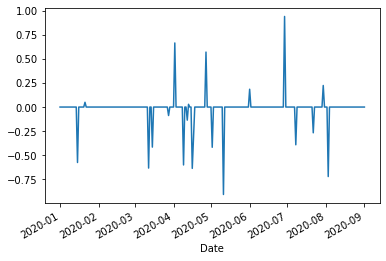

In [1081]:
size.plot()

### Examine portfolio methods

In [378]:
portfolio.share_flow()
portfolio.shares()

portfolio.cash_flow()
portfolio.cash()

portfolio.daily_returns(group_by=None)

symbol                               AMC                                   BB  \
oc_hx_contract_symbol AMC210122C00002500 AMC210122C00003000 BB210108C00007000   
Date                                                                            
2019-01-02                      0.000000           0.000000               0.0   
2019-01-04                      0.000000           0.000000               0.0   
2019-01-14                      0.000000           0.000000               0.0   
2019-01-15                      0.000000           0.000000               0.0   
2019-01-18                      0.000000           0.000000               0.0   
...                                  ...                ...               ...   
2021-01-15                      0.560953           0.196810               0.0   
2021-01-19                      0.359366           0.271523               0.0   
2021-01-20                     -0.084596          -0.244047               0.0   
2021-01-21                     -0.069310          -0.201771               0.0   
2021-01-22                      0.655356           1.033847               0.0   

symbol                                                 FEYE  \
oc_hx_contract_symbol BB210122C00007000 FEYE201218C00016000   
Date                                                          
2019-01-02                     0.000000                 0.0   
2019-01-04                     0.000000                 0.0   
2019-01-14                     0.000000                 0.0   
2019-01-15                     0.000000                 0.0   
2019-01-18                     0.000000                 0.0   
...                                 ...                 ...   
2021-01-15                     0.296104                 0.0   
2021-01-19                     0.797945                 0.0   
2021-01-20                     0.073661                 0.0   
2021-01-21                     0.017152                 0.0   
2021-01-22                     0.199992                 0.0   

symbol                                                         \
oc_hx_contract_symbol FEYE201224C00014000 FEYE210115C00015000   
Date                                                            
2019-01-02                            0.0            0.000000   
2019-01-04                            0.0            0.000000   
2019-01-14                            0.0            0.000000   
2019-01-15                            0.0            0.000000   
2019-01-18                            0.0            0.000000   
...                                   ...                 ...   
2021-01-15                            0.0           -0.043013   
2021-01-19                            0.0            0.000000   
2021-01-20                            0.0            0.000000   
2021-01-21                            0.0            0.000000   
2021-01-22                            0.0            0.000000   

symbol                                                         
oc_hx_contract_symbol FEYE210115C00016000 FEYE210115C00017000  
Date                                                           
2019-01-02                       0.000000            0.000000  
2019-01-04                       0.000000            0.000000  
2019-01-14                       0.000000            0.000000  
2019-01-15                       0.000000            0.000000  
2019-01-18                       0.000000            0.000000  
...                                   ...                 ...  
2021-01-15                      -0.044963            0.003163  
2021-01-19                       0.000000            0.000000  
2021-01-20                       0.000000            0.000000  
2021-01-21                       0.000000            0.000000  
2021-01-22                       0.000000            0.000000  

[440 rows x 9 columns]

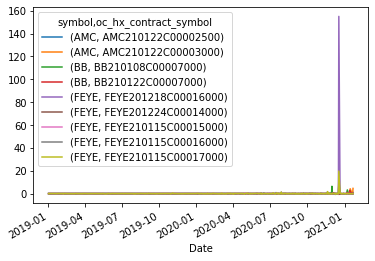

In [379]:
portfolio.market_returns().plot()

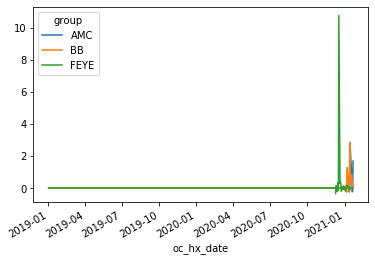

In [825]:
portfolio.active_returns().plot()

In [893]:
portfolio.cumulative_returns()

exit_type                     expiration                                       \
symbol                               AMC                                   BB   
oc_hx_contract_symbol AMC210122C00002500 AMC210122C00003000 BB210108C00007000   
Date                                                                            
2019-01-02                      0.000000           0.000000          0.000000   
2019-01-04                      0.000000           0.000000          0.000000   
2019-01-14                      0.000000           0.000000          0.000000   
2019-01-15                      0.000000           0.000000          0.000000   
2019-01-18                      0.000000           0.000000          0.000000   
...                                  ...                ...               ...   
2021-01-15                      0.525892           0.130946          0.492093   
2021-01-19                      1.074246           0.438024          0.492093   
2021-01-20                      0.898773           0.087078          0.492093   
2021-01-21                      0.767168          -0.132263          0.492093   
2021-01-22                      1.925292           0.764844          0.492093   

exit_type                                                    \
symbol                                                 FEYE   
oc_hx_contract_symbol BB210122C00007000 FEYE201218C00016000   
Date                                                          
2019-01-02                     0.000000            0.000000   
2019-01-04                     0.000000            0.000000   
2019-01-14                     0.000000            0.000000   
2019-01-15                     0.000000            0.000000   
2019-01-18                     0.000000            0.000000   
...                                 ...                 ...   
2021-01-15                     5.624678            3.337961   
2021-01-19                    10.910804            3.337961   
2021-01-20                    11.788169            3.337961   
2021-01-21                    12.007511            3.337961   
2021-01-22                    14.608914            3.337961   

exit_type                                                      \
symbol                                                          
oc_hx_contract_symbol FEYE201224C00014000 FEYE210115C00015000   
Date                                                            
2019-01-02                       0.000000              0.0000   
2019-01-04                       0.000000              0.0000   
2019-01-14                       0.000000              0.0000   
2019-01-15                       0.000000              0.0000   
2019-01-18                       0.000000              0.0000   
...                                   ...                 ...   
2021-01-15                       8.458534             14.3232   
2021-01-19                       8.458534             14.3232   
2021-01-20                       8.458534             14.3232   
2021-01-21                       8.458534             14.3232   
2021-01-22                       8.458534             14.3232   

exit_type                                                      
symbol                                                         
oc_hx_contract_symbol FEYE210115C00016000 FEYE210115C00017000  
Date                                                           
2019-01-02                       0.000000            0.000000  
2019-01-04                       0.000000            0.000000  
2019-01-14                       0.000000            0.000000  
2019-01-15                       0.000000            0.000000  
2019-01-18                       0.000000            0.000000  
...                                   ...                 ...  
2021-01-15                       6.270163            5.679608  
2021-01-19                       6.270163            5.679608  
2021-01-20                       6.270163            5.679608  
2021-01-21                    

In [381]:
portfolio.returns_stats()

Start                    2019-01-02 00:00:00
End                      2021-01-22 00:00:00
Duration                   440 days 00:00:00
Total Return [%]                     620.673
Benchmark Return [%]                 249.403
Annual Return [%]                    190.121
Annual Volatility [%]                235.284
Sharpe Ratio                        0.899071
Calmar Ratio                          10.322
Max. Drawdown [%]                   -21.9264
Omega Ratio                          14.0621
Sortino Ratio                        18.3893
Skew                                 18.4034
Kurtosis                             362.085
Tail Ratio                               inf
Common Sense Ratio                       inf
Value at Risk                              0
Alpha                               0.238654
Beta                                0.338572
Name: <lambda>, dtype: object

In [382]:
portfolio.final_value()

symbol  oc_hx_contract_symbol
AMC     AMC210122C00002500        2667.34267
        AMC210122C00003000        1609.22161
BB      BB210108C00007000         1360.52136
        BB210122C00007000        14232.53426
FEYE    FEYE201218C00016000       3955.44396
        FEYE201224C00014000       8624.48864
        FEYE210115C00015000      13972.01400
        FEYE210115C00016000       6629.08664
        FEYE210115C00017000       6090.60610
dtype: float64

In [383]:
portfolio.value_at_risk()

symbol  oc_hx_contract_symbol
AMC     AMC210122C00002500       0.0
        AMC210122C00003000       0.0
BB      BB210108C00007000        0.0
        BB210122C00007000        0.0
FEYE    FEYE201218C00016000      0.0
        FEYE201224C00014000      0.0
        FEYE210115C00015000      0.0
        FEYE210115C00016000      0.0
        FEYE210115C00017000      0.0
dtype: float64

In [384]:
portfolio.total_market_return()

symbol  oc_hx_contract_symbol
AMC     AMC210122C00002500      -0.408284
        AMC210122C00003000      -0.545455
BB      BB210108C00007000        2.928571
        BB210122C00007000        4.600000
FEYE    FEYE201218C00016000      5.240000
        FEYE201224C00014000      4.857143
        FEYE210115C00015000      0.458333
        FEYE210115C00016000      4.931373
        FEYE210115C00017000      0.384615
dtype: float64

In [385]:
portfolio.total_profit()

symbol  oc_hx_contract_symbol
AMC     AMC210122C00002500        1755.52176
        AMC210122C00003000         697.40070
BB      BB210108C00007000          448.70045
        BB210122C00007000        13320.71335
FEYE    FEYE201218C00016000       3043.62305
        FEYE201224C00014000       7712.66773
        FEYE210115C00015000      13060.19309
        FEYE210115C00016000       5717.26573
        FEYE210115C00017000       5178.78519
dtype: float64

In [386]:
portfolio.calmar_ratio()

symbol  oc_hx_contract_symbol
AMC     AMC210122C00002500        5.736280
        AMC210122C00003000        0.969567
BB      BB210108C00007000         4.678717
        BB210122C00007000        17.216463
FEYE    FEYE201218C00016000      23.956562
        FEYE201224C00014000      14.418895
        FEYE210115C00015000      12.579984
        FEYE210115C00016000       7.258759
        FEYE210115C00017000       6.083076
dtype: float64

In [387]:
# portfolio.get_drawdowns()
portfolio.max_drawdown(group_by=False)
# portfolio.drawdown()

symbol  oc_hx_contract_symbol
AMC     AMC210122C00002500      -0.148043
        AMC210122C00003000      -0.396577
BB      BB210108C00007000       -0.055055
        BB210122C00007000       -0.222158
FEYE    FEYE201218C00016000     -0.054989
        FEYE201224C00014000     -0.181806
        FEYE210115C00015000     -0.300000
        FEYE210115C00016000     -0.291344
        FEYE210115C00017000     -0.323401
dtype: float64

In [389]:
portfolio.value().vbt.plot()

FigureWidget({
    'data': [{'name': "('AMC', 'AMC210122C00002500')",
              'showlegend': True,
      …

In [390]:
portfolio.total_return(group_by=False)

symbol  oc_hx_contract_symbol
AMC     AMC210122C00002500        1.925292
        AMC210122C00003000        0.764844
BB      BB210108C00007000         0.492093
        BB210122C00007000        14.608914
FEYE    FEYE201218C00016000       3.337961
        FEYE201224C00014000       8.458534
        FEYE210115C00015000      14.323200
        FEYE210115C00016000       6.270163
        FEYE210115C00017000       5.679608
dtype: float64

### Figure out how to extract trade details

In [943]:
trade_df = portfolio.logs.records
trade_df[trade_df['order_id'] != -1].head().T

,432,433,439,870,875
id,432,433,439,870,875
idx,432,433,439,430,435
col,0,0,0,1,1
group,0,0,0,1,1
cash_now,inf,inf,inf,inf,inf
shares_now,0,1000,2000,0,1000
val_price_now,0.14,0.1,1,0.09,0.21
value_now,inf,inf,inf,inf,inf
size,1000,1000,-2000,1000,1000
size_type,0,0,0,0,0


In [950]:
portfolio.value().sum(axis=1)

Date
2019-01-02     8206.38819
2019-01-04     8206.38819
2019-01-14     8206.38819
2019-01-15     8206.38819
2019-01-18     8206.38819
                 ...     
2021-01-15    49095.24224
2021-01-19    54695.24224
2021-01-20    55015.24224
2021-01-21    54895.24224
2021-01-22    59141.25924
Length: 440, dtype: float64

In [949]:
portfolio['expiration']['AMC'].value().sum(axis=1)

Date
2019-01-02     601.20060
2019-01-04     601.20060
2019-01-14     601.20060
2019-01-15     601.20060
2019-01-18     601.20060
                 ...    
2021-01-15    1200.12006
2021-01-19    1980.12006
2021-01-20    1500.12006
2021-01-21    1180.12006
2021-01-22    3054.12306
Length: 440, dtype: float64

In [951]:
# portfolio.plot(column='BTC-USD')
# portfolio.plot(index='BTC-USD')
portfolio.stats()

Start                     2019-01-02 00:00:00
End                       2021-01-22 00:00:00
Duration                    440 days 00:00:00
Init. Cash                            911.821
Total Profit                          5659.43
Total Return [%]                      620.673
Benchmark Return [%]                  249.403
Position Coverage [%]                 3.13131
Max. Drawdown [%]                     21.9264
Avg. Drawdown [%]                     13.8066
Max. Drawdown Duration       11 days 16:00:00
Avg. Drawdown Duration        7 days 09:46:40
Num. Trades                                 1
Win Rate [%]                              100
Best Trade [%]                        1680.42
Worst Trade [%]                       1680.42
Avg. Trade [%]                        1680.42
Max. Trade Duration          13 days 18:40:00
Avg. Trade Duration          13 days 18:40:00
Expectancy                            5659.43
SQN                                       NaN
Gross Exposure                    

In [954]:
portfolio.get_trades()